In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

### Downsampling

In [7]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [60]:
# def downsample(X, y, df_test):
#     rds = RandomUnderSampler()
    
#     # Resample
#     X_downsampled, y_downsampled = rds.fit_resample(X, y)

#     # Recreate dataframe
#     X_downsampled = pd.DataFrame(data=X_downsampled, columns=X.columns)
#     y_downsampled = pd.DataFrame(data=y_downsampled, columns=['DeviceType'])

#     # Onehot encode 'DeviceType'
#     devicetype_series = pd.get_dummies(y_downsampled['DeviceType'])
#     y_downsampled = pd.concat([y_downsampled, devicetype_series], axis=1)
#     y_downsampled = y_downsampled.drop(['DeviceType'],axis=1)

#     # Combine X and y into one dataframe
#     df_train_downsampled = pd.concat([X_downsampled, y_downsampled], axis=1)
    
#     # Reinsert Set and DeviceType columns to training dataset
#     df_train_downsampled['Set'] = 'train'

#     # Ensure same number of columns in both training and test datasets
#     train_cols = df_train_downsampled.columns
#     df_test_samecols = df_test[train_cols]

#     # Combine training and test sets into one dataframe
#     df_downsampled = pd.concat([df_train_downsampled,df_test_samecols],axis=0)    
    
#     return df_downsampled

### Create trial dataframes

In [61]:
df_trials = []
for i in range(0,10):
    df_downsampled = downsample(X, y, df_test)
    df_trials.append(df_downsampled)

### Plots

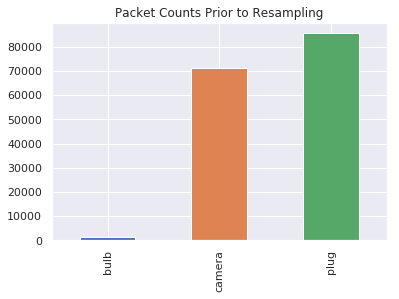

In [54]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

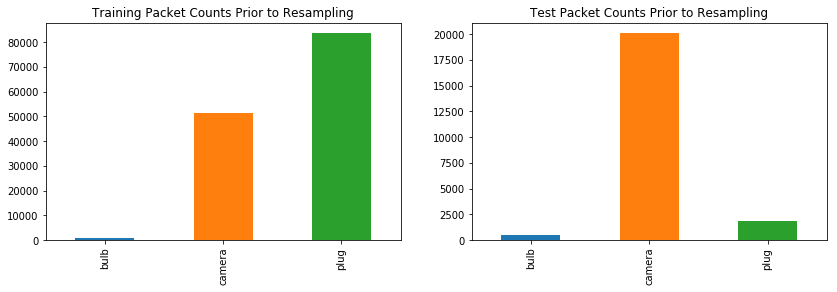

In [11]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


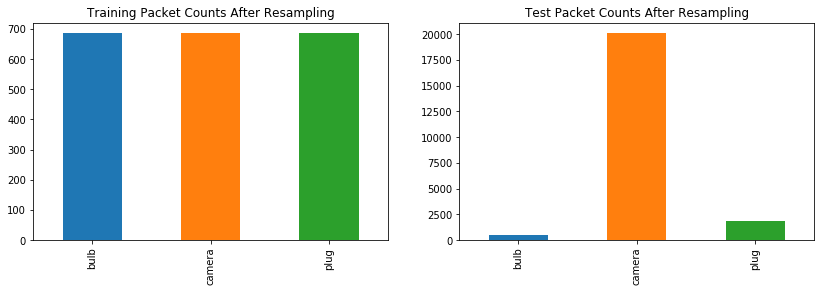

In [12]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");


# Run All vs One classification

In [55]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

In [15]:
# one_under_devtype = w.one_vs_one_classify(df_downsampled, features_list, y_list)

In [59]:
all_under_devtype = w.one_vs_all_classify(df_downsampled, features_list, y_list)

Device Type: camera
RF


Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall        F1
camera  18040    397  2018  2077  0.181742   0.839531  0.103246  0.183879
rest      397  18040  2077  2018  0.181742   0.100608  0.835611  0.179593
---------------------------------------------------------
KNN


Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall        F1
camera  11381    816  1599  8736  0.458681   0.914573  0.434260  0.588898
rest      816  11381  8736  1599  0.458681   0.123190  0.662112  0.207730
---------------------------------------------------------
LDA


Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall        F1
camera  19016     80  2335  1101  0.152494   0.932261  0.054730  0.103390
rest       80  19016  1101  2335  0.152494   0.109363  0.966874  0.196499
---------------------------------------------------------
Total time (classifiers): 0.297367095947

Device Type: bulb
RF


Metrics
       FN   FP     TN     

## Reports

In [17]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### Confusion Matrix

In [18]:
# Extract confusion matrices
device_cms = []
for device in sorted(device_types):
    classifier_cms = []
    for classifier in sorted(classifiers):
        classifier_cms.append(all_under_devtype[0][device][classifier]['CM'])
    device_cms.append(classifier_cms)


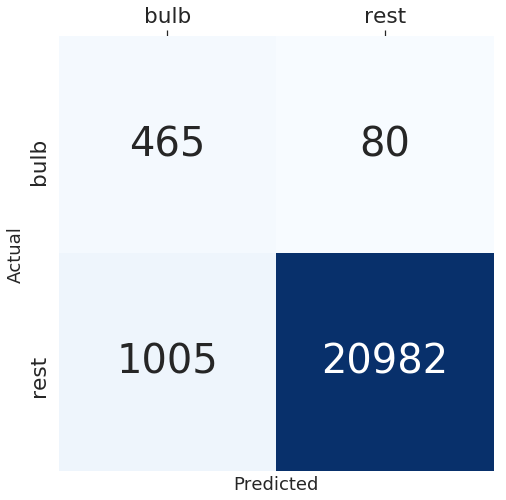

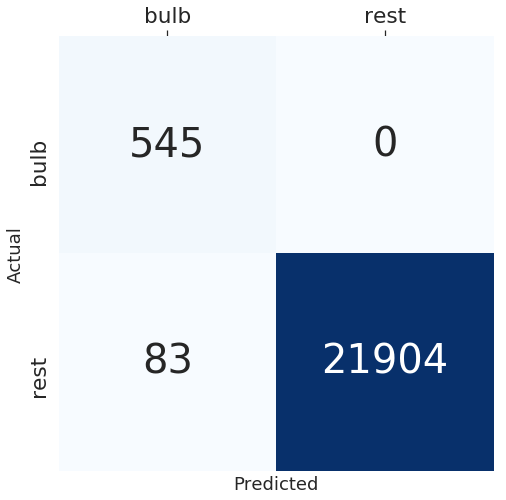

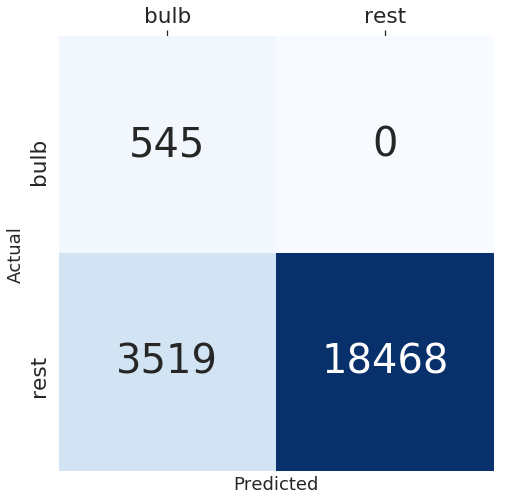

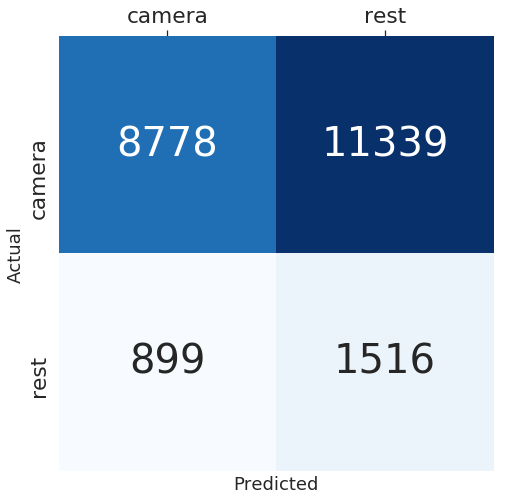

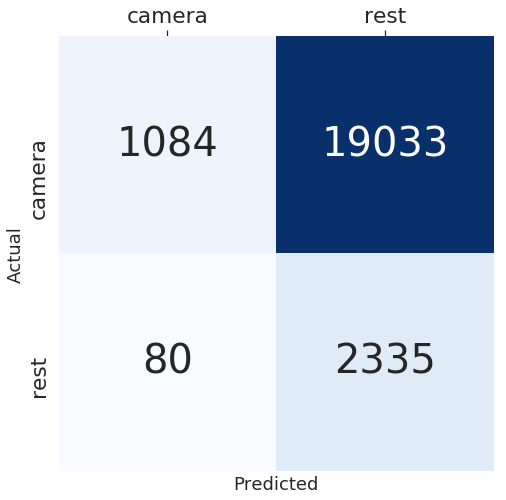

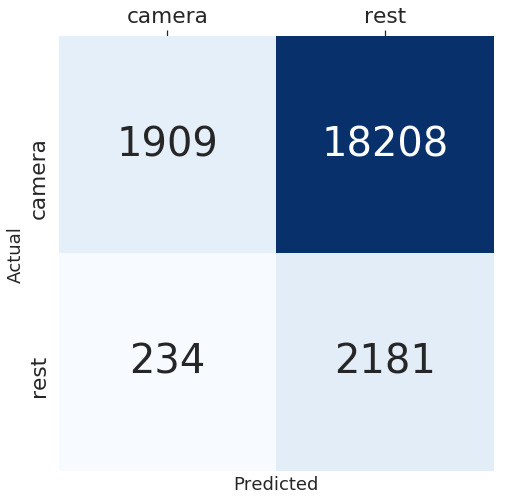

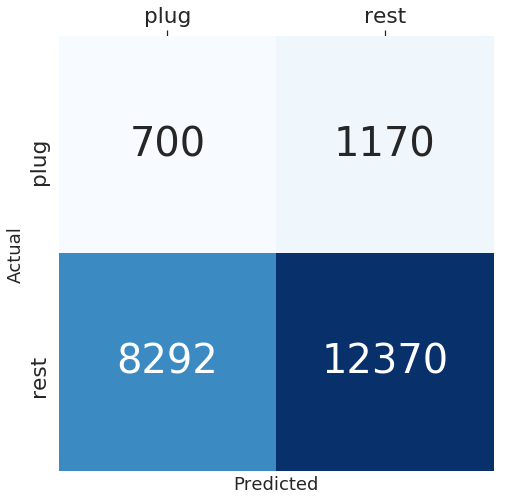

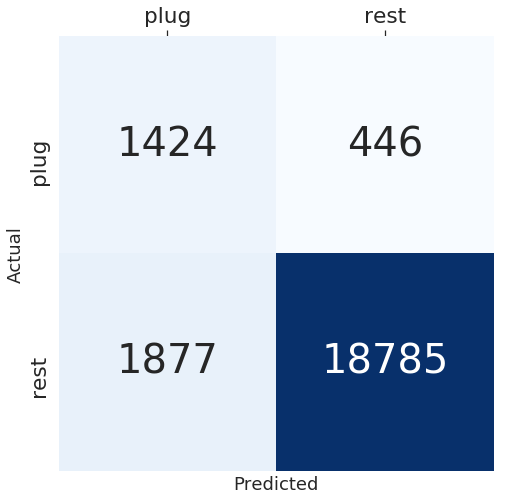

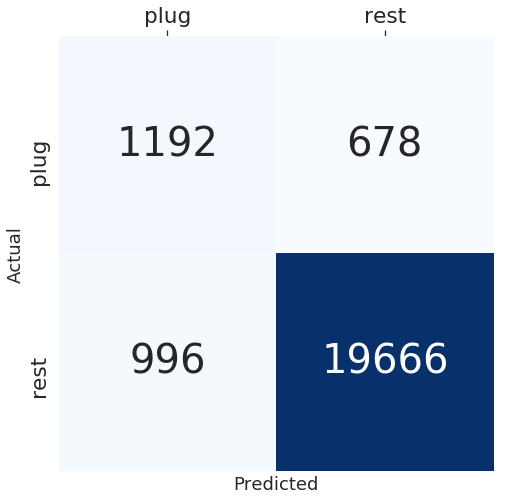

In [19]:
sns.set(font_scale=1.5)
for device_list in device_cms:
    for classifier_cm in device_list:
        fig, ax = plt.subplots(figsize=(11,8))
        ax.tick_params(labelsize='large')
        ax.xaxis.set_ticks_position('top')
        sns.heatmap(classifier_cm, annot=True, annot_kws={"size":40},square=True, fmt='d', cmap='Blues', cbar=False);

### Accuracy, Precision, Recall

In [20]:
# Extract metrics
device_metrics = []
for device in sorted(device_types):
    classifier_metrics = []
    for classifier in sorted(classifiers):
        classifier_metrics.append(all_under_devtype[0][device][classifier]['Metrics'][['Accuracy','Precision','Recall']].loc[device])
    device_metrics.append(classifier_metrics)


In [21]:
for device_list in device_metrics:
    for classifier_metrics, c in zip(device_list, classifiers):
        print c
        print classifier_metrics, "\n"

KNN
Accuracy     0.951846
Precision    0.316327
Recall       0.853211
Name: bulb, dtype: float64 

LDA
Accuracy     0.996316
Precision    0.867834
Recall       1.000000
Name: bulb, dtype: float64 

RF
Accuracy     0.843822
Precision    0.134104
Recall       1.000000
Name: bulb, dtype: float64 

KNN
Accuracy     0.456861
Precision    0.907099
Recall       0.436347
Name: camera, dtype: float64 

LDA
Accuracy     0.151740
Precision    0.931271
Recall       0.053885
Name: camera, dtype: float64 

RF
Accuracy     0.181520
Precision    0.890807
Recall       0.094895
Name: camera, dtype: float64 

KNN
Accuracy     0.580064
Precision    0.077847
Recall       0.374332
Name: plug, dtype: float64 

LDA
Accuracy     0.896902
Precision    0.431384
Recall       0.761497
Name: plug, dtype: float64 

RF
Accuracy     0.925706
Precision    0.544790
Recall       0.637433
Name: plug, dtype: float64 



### AUC

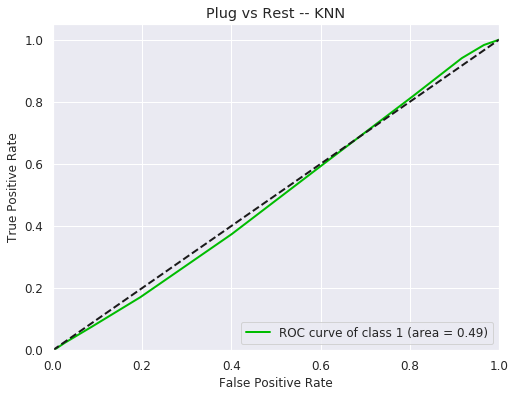

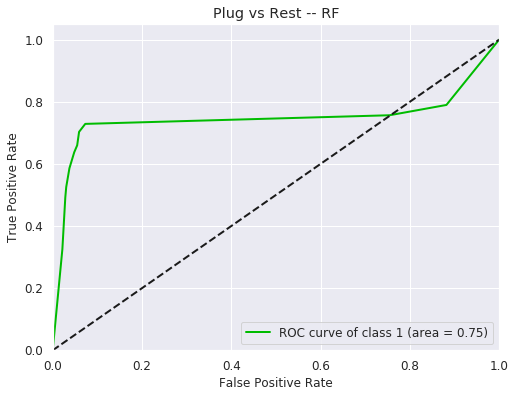

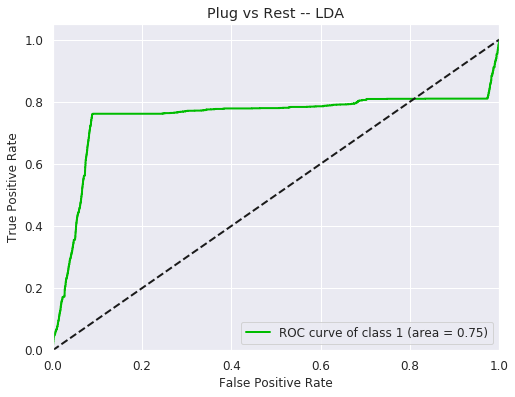

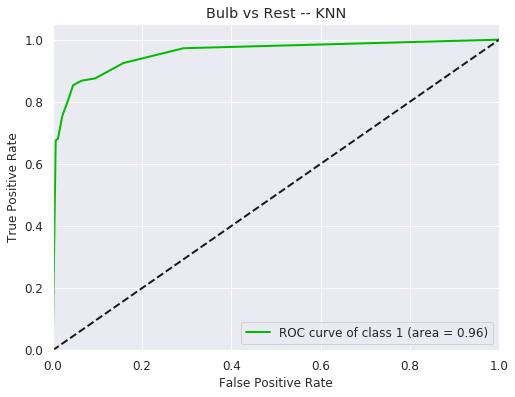

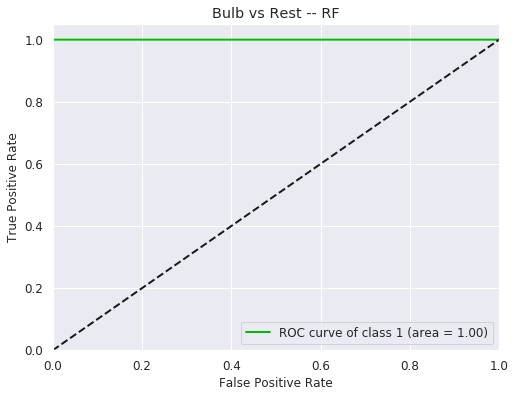

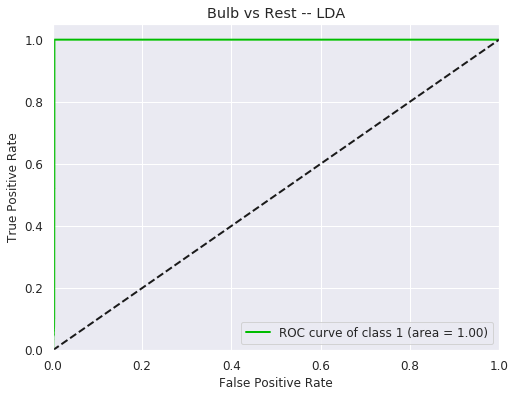

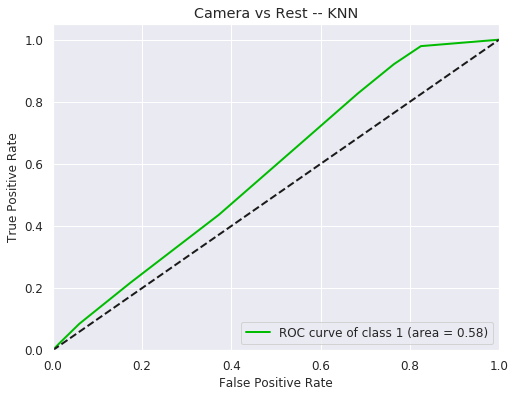

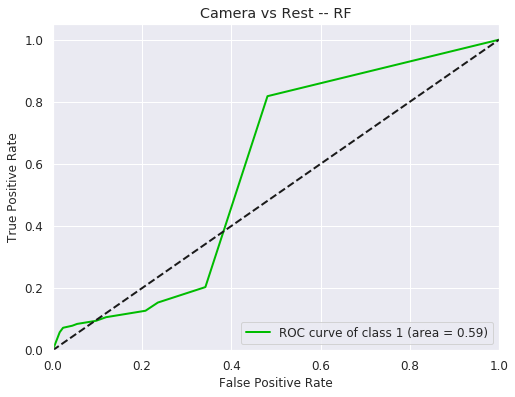

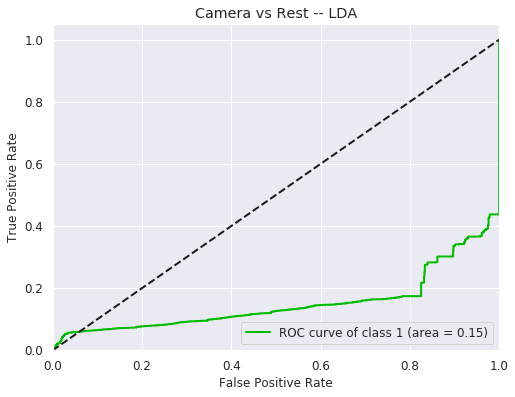

In [22]:
# Plotting ROC curves
sns.set(font_scale=1)

# Extract devices and classifiers
dev_pairs = all_under_devtype[0].keys()
classifiers = all_under_devtype[0][dev_pairs[0]].keys()

for device in dev_pairs:
    for classifier in classifiers:
        # Extract predicted probas and y_true
        pred_proba = all_under_devtype[0][device][classifier]['Classifier']['Pred_Proba']
        true = all_under_devtype[0][device][classifier]['Classifier']['True']
        
        # Plot ROC curve
        fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
        auc = roc_auc_score(true, pred_proba[:,1])
        title = str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
        skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                               classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [23]:
print "Total time:", all_under_devtype[1], "seconds"

for device in device_types:
    for classifier in classifiers:
        title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
        print title, ":", all_under_devtype[0][device][classifier]['Classifier']['Time'], "seconds"

Total time: 1.51360583305 seconds
(Bulb, KNN) : 0.220189809799 seconds
(Bulb, RF) : 0.0564761161804 seconds
(Bulb, LDA) : 0.00692296028137 seconds
(Camera, KNN) : 0.225200891495 seconds
(Camera, RF) : 0.0656261444092 seconds
(Camera, LDA) : 0.02068400383 seconds
(Plug, KNN) : 0.257229089737 seconds
(Plug, RF) : 0.062047958374 seconds
(Plug, LDA) : 0.0076150894165 seconds


### Feature Importance

In [24]:
feature_importances = pd.DataFrame(w.randomforest.feature_importances_,
                                   index = features_list,
                                    columns=['importance']).sort_values('importance',ascending=False)
display(feature_importances)

,importance
Belkin,0.560510
Assoc_Packets,0.125923
PacketLength,0.115132
Dropcam,0.080336
Time,0.040873
Data,0.037761
QoS_Null,0.016149
Lifi,0.015075
QoS_Data,0.008205
Tp-link,0.000036
